<a href="https://colab.research.google.com/github/grinaldo-oliveira/SibGrapi/blob/main/Classifica%C3%A7%C3%A3o_MLP_UNI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Doutorado/SibGrapi

/content/drive/MyDrive/Doutorado/SibGrapi


Iniciando processamento em: 2025-05-20 00:14:39

Processando arquivo: Data/Sclerosis/UNI/UNI.npy
-Quantidade de Amostras: 13906
-Quantidade de Embeddings: 1024
-Quantidade de Linhas: 13906
-Coeficiente: 1
-Shape dos Embeddings: (13906, 1024)
Carregando folds de checkpoints/folds_indices_Data_Sclerosis.json
Embeddings carregados com sucesso:
- Formato dos embeddings: (13906, 1024)
- Número de classes: 2
- Classes: ['others', 'Sclerosis']
- Formato das labels: (13906, 1)
- Modelo usado: UNI
Classes alvo identificadas: ['Sclerosis']
Resultados carregados: checkpoints/results/UNI_Sclerosis_results.json
Todos os resultados para Data/Sclerosis/UNI/UNI.npy já estão disponíveis. Usando dados existentes.

Processando arquivo: Data/Podocitopatia/UNI/UNI.npy
-Quantidade de Amostras: 14038
-Quantidade de Embeddings: 1024
-Quantidade de Linhas: 14038
-Coeficiente: 1
-Shape dos Embeddings: (14038, 1024)
Carregando folds de checkpoints/folds_indices_Data_Podocitopatia.json
Embeddings carregados com s

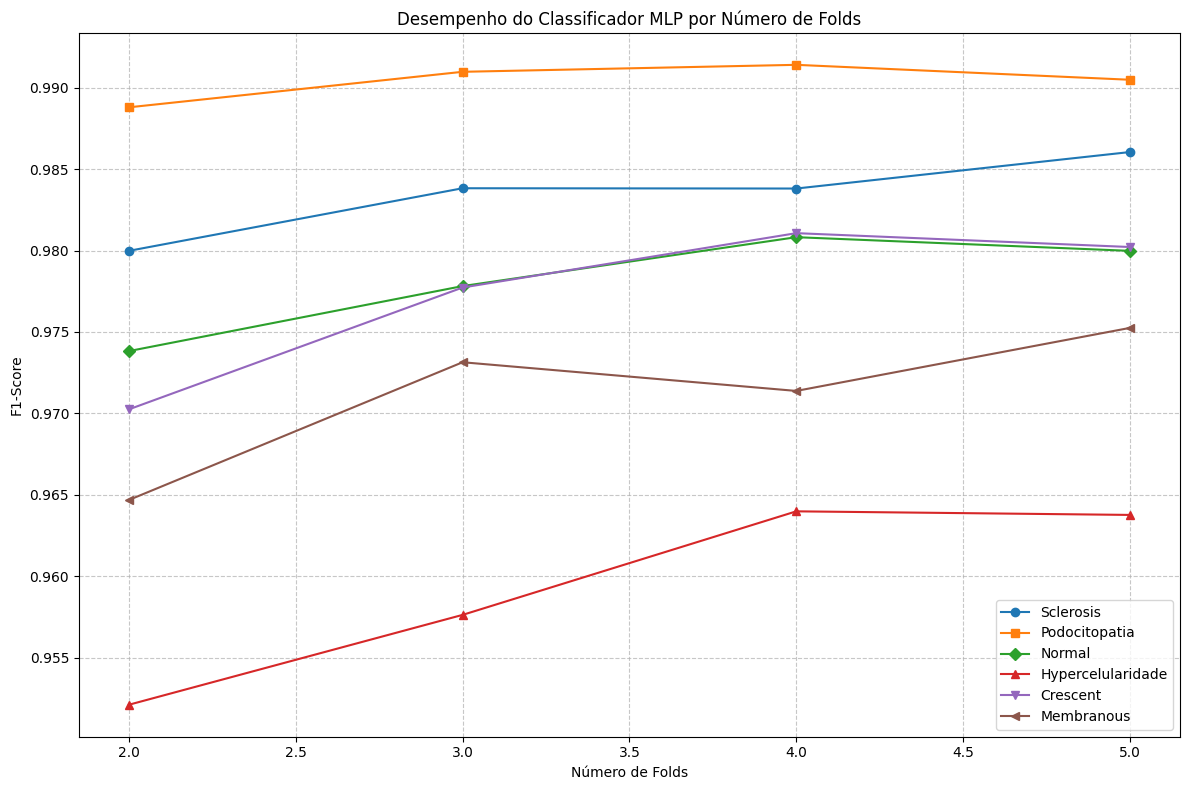

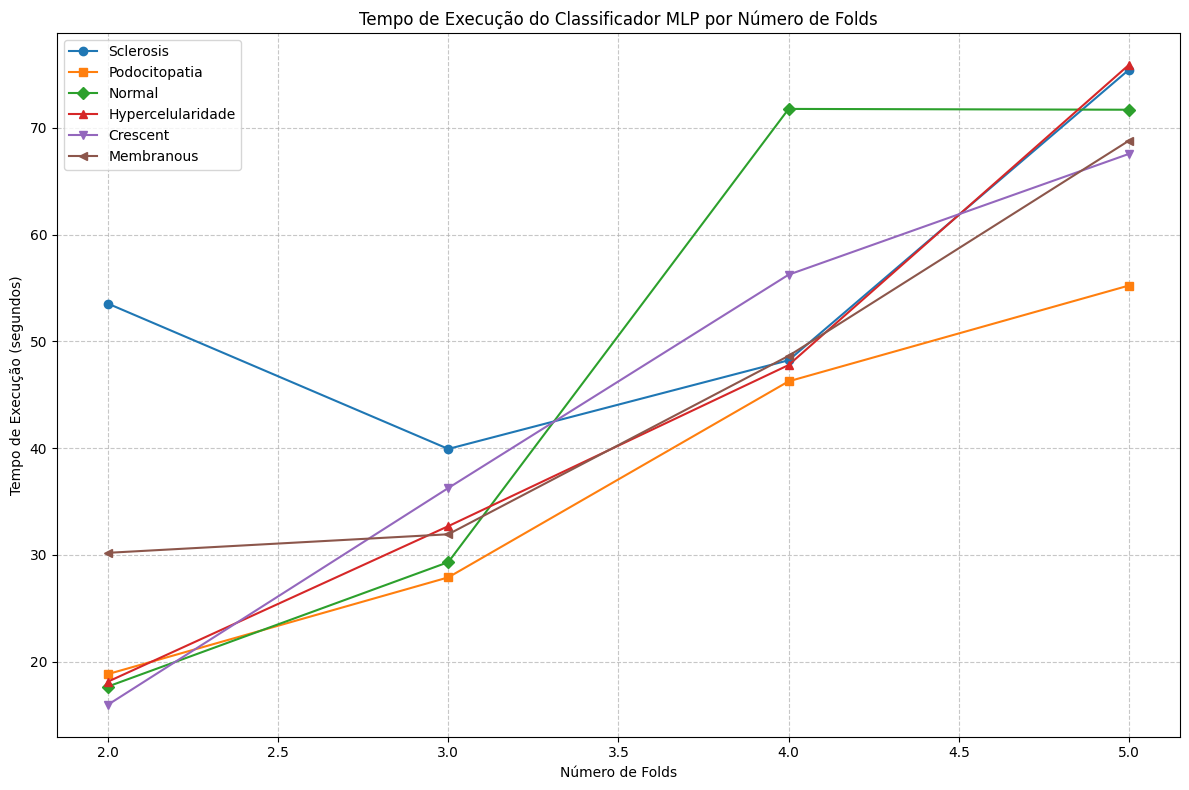

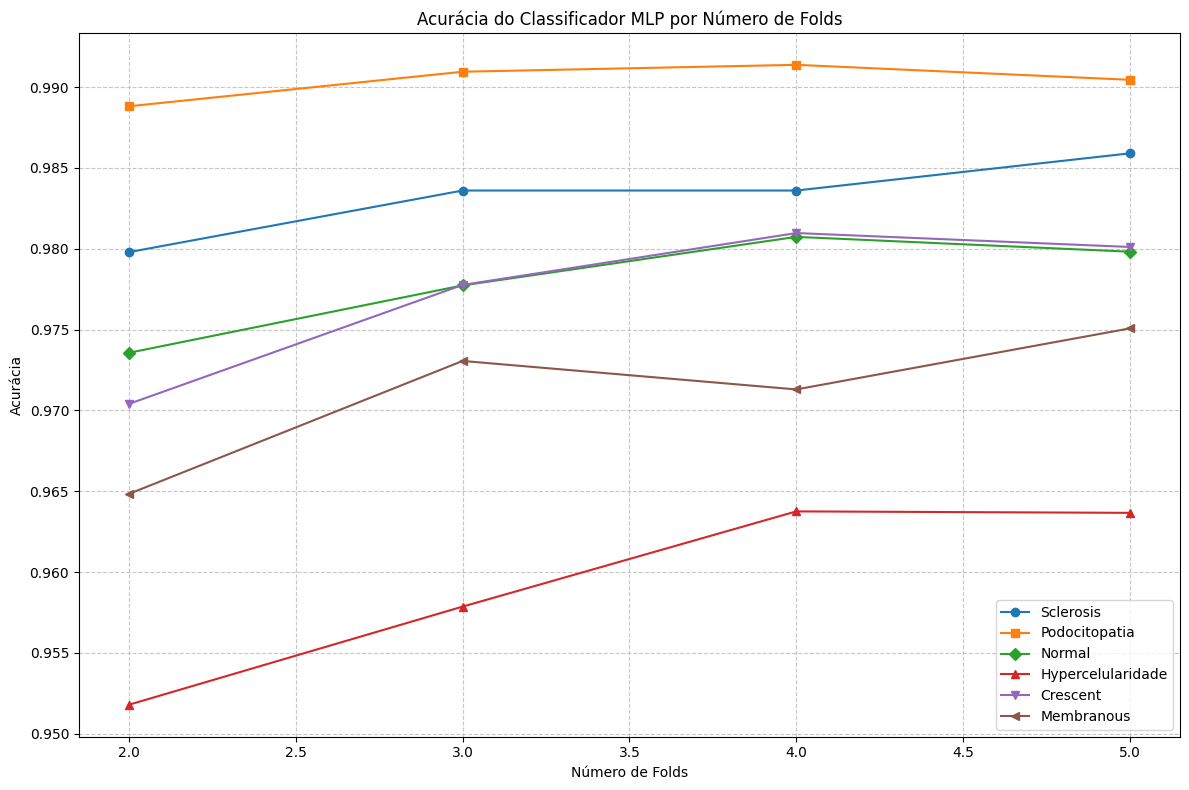

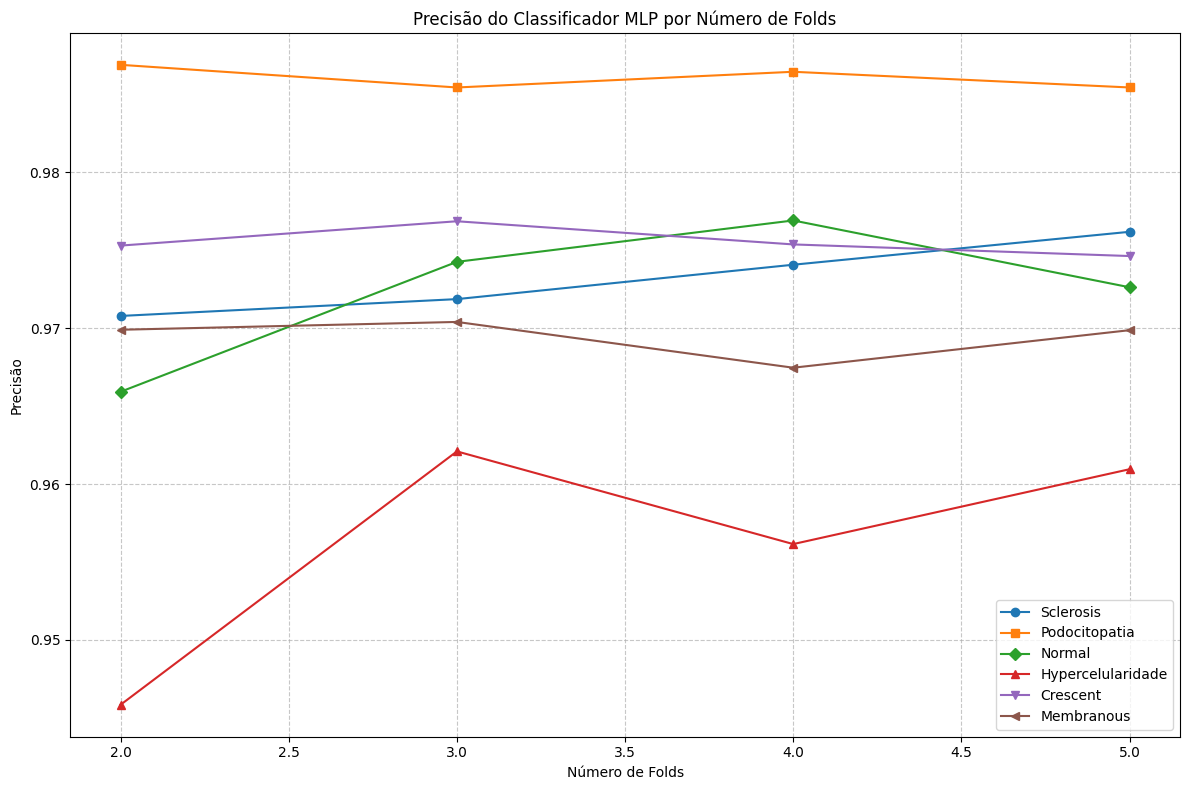

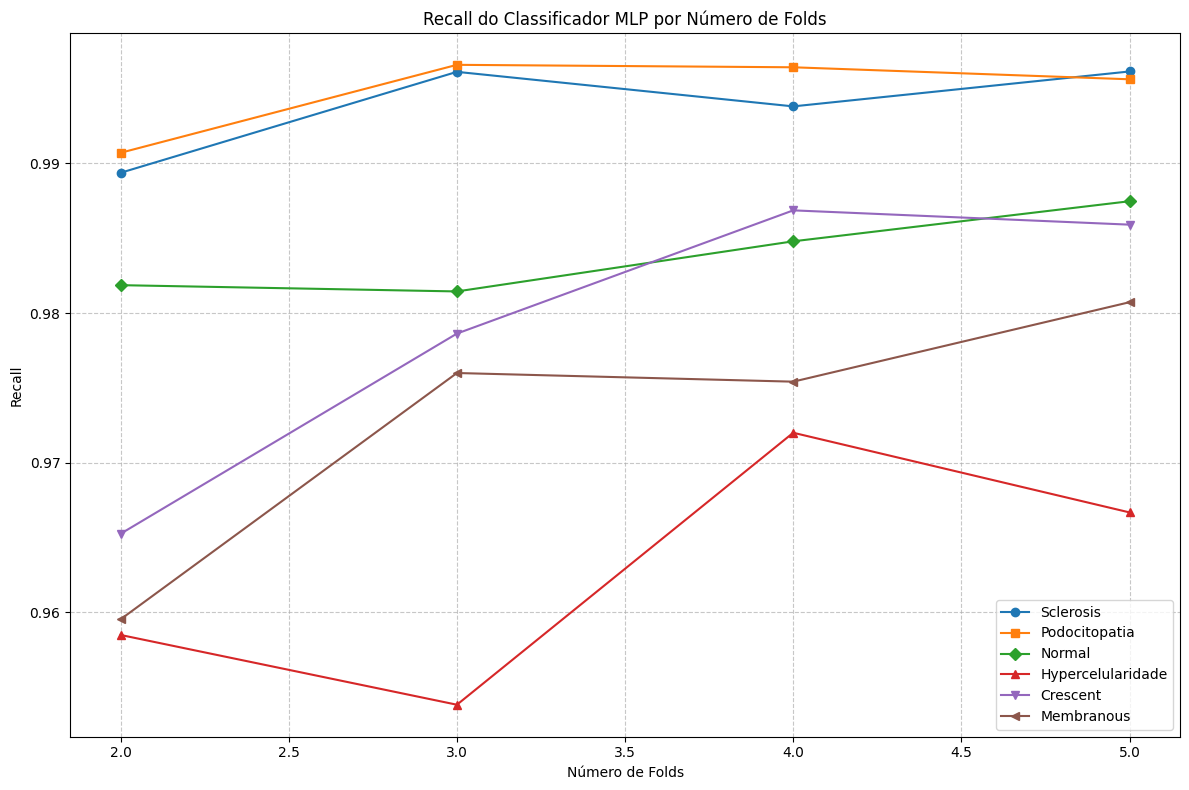


                RESULTADOS F1-SCORE POR FOLD - CLASSIFICADOR MLP                

Tabela de F1-Score por Número de Folds - MLP:
Folds                   2       3       4       5
Classe                                           
Crescent           0.9702  0.9777  0.9811  0.9802
Hypercelularidade  0.9521  0.9576  0.9640  0.9638
Membranous         0.9647  0.9731  0.9714  0.9753
Normal             0.9738  0.9778  0.9808  0.9800
Podocitopatia      0.9888  0.9910  0.9914  0.9905
Sclerosis          0.9800  0.9838  0.9838  0.9861

Resultados salvos em 'resultados_f1_score_MLP.csv'

Tabela Detalhada - MLP:
               Classe  Folds  F1-Score
16           Crescent      2    0.9702
17           Crescent      3    0.9777
18           Crescent      4    0.9811
19           Crescent      5    0.9802
12  Hypercelularidade      2    0.9521
13  Hypercelularidade      3    0.9576
14  Hypercelularidade      4    0.9640
15  Hypercelularidade      5    0.9638
20         Membranous      2    0.9647
21  

In [ ]:
# UNI

import os
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import sys
import pickle
import json
from datetime import datetime
import re

# Diretório para salvar os checkpoints
CHECKPOINT_DIR = "checkpoints"
MODEL_DIR = os.path.join(CHECKPOINT_DIR, "models")
RESULTS_DIR = os.path.join(CHECKPOINT_DIR, "results")
CONFUSION_MATRIX_DIR = os.path.join(CHECKPOINT_DIR, "confusion_matrices")

MODEL_NAME_TO_OUTPUT_DIM = {
    "uni": 1024,
    "uni2": 1536,
    "phikon": 768,
    "phikonv2": 1024
}


def ensure_dirs_exist():
    """Cria diretórios necessários se não existirem"""
    for directory in [CHECKPOINT_DIR, MODEL_DIR, RESULTS_DIR, CONFUSION_MATRIX_DIR]:
        if not os.path.exists(directory):
            os.makedirs(directory)
            print(f"Diretório criado: {directory}")

def check_file_paths(file_paths):
    """
    Verifica se todos os caminhos de arquivo existem.

    Args:
        file_paths: Lista de caminhos de arquivo para verificar

    Returns:
        bool: True se todos os arquivos existem, False caso contrário
    """
    all_exist = True
    for path in file_paths:
        if not os.path.exists(path):
            print(f"ERRO: O arquivo '{path}' não existe.")
            all_exist = False

        # Verificar também se o arquivo de informações existe
        if all_exist:
            base_name, ext = os.path.splitext(path)
            info_path = f"{base_name}_info{ext}"
            if not os.path.exists(info_path):
                print(f"ERRO: O arquivo de informações '{info_path}' não existe.")
                all_exist = False

    return all_exist

def load_embed(pickle_path: str) -> tuple:
    """
    Carrega embeddings e informações relacionadas de um arquivo pickle.
    Args:
        pickle_path: Caminho para o arquivo pickle contendo os embeddings
    Returns:
        tuple: (embeddings, labels, classes, file_refs, model)
    """
    # Preparar caminho para o arquivo de informações
    base_name, ext = os.path.splitext(pickle_path)
    info_path = f"{base_name}_info{ext}"
    # Carregar metadados do arquivo de informações
    data = np.load(info_path, allow_pickle=True).tolist()
    model = data['model']
    file_refs = data['fnames']
    classes = data['classes']
    labels = np.vstack(data['labels'])
    # Carregar embeddings do arquivo memmap principal
    fp = np.memmap(pickle_path,  mode='r', dtype=np.float64)

    # Calcular o tamanho da dimensão do embedding dividindo pelo número de classes
    num_samples = len(file_refs)
    print(f"-Quantidade de Amostras: {num_samples}")
    embed_dim = MODEL_NAME_TO_OUTPUT_DIM[model.lower()]
    print(f"-Quantidade de Embeddings: {embed_dim}")
    # Calculate n_rows based on the actual embed_dim to get the correct number of samples
    n_rows = len(fp) // embed_dim
    print(f"-Quantidade de Linhas: {n_rows}")
    coificient = int (n_rows / num_samples)
    print(f"-Coeficiente: {coificient}")
    # Reshape o memmap baseado no número de classes e na dimensão calculada
    #embeds = fp[:n_rows * embed_dim ].reshape(n_rows, embed_dim)
    embeds = fp.reshape(n_rows, embed_dim)
    print(f"-Shape dos Embeddings: {embeds.shape}")
    return embeds, labels, classes, file_refs, model

def prepare_binary_classification_data(embeds, labels, classes, target_class):
    """
    Prepara os dados para classificação binária, onde a classe alvo é 1 e todas as outras são 0.
    Args:
        embeds: Embeddings dos dados
        labels: Labels dos dados (one-hot encoded ou não)
        classes: Lista de nomes das classes
        target_class: Nome da classe alvo
    Returns:
        tuple: (X, y) onde X são os embeddings e y são as labels binárias
    """
    # Encontrar o índice da classe alvo
    if target_class not in classes:
        raise ValueError(f"A classe '{target_class}' não foi encontrada na lista de classes.")

    target_idx = classes.index(target_class)

    # Verificar a forma do array de labels
    print(f"Forma do array de labels: {labels.shape}")

    # Verificar se as labels estão no formato one-hot ou não
    if len(labels.shape) == 2 and labels.shape[1] == len(classes):
        # Labels estão em formato one-hot
        y_binary = labels[:, target_idx].astype(int)
    elif len(labels.shape) == 2 and labels.shape[1] == 1:
        # Labels estão em formato de índice único por linha
        y_binary = (labels.flatten() == target_idx).astype(int)
    else:
        # Tentar interpretar as labels de outra forma
        # Assumir que labels contém os índices das classes
        y_binary = np.zeros(len(labels), dtype=int)
        for i in range(len(labels)):
            # Se o valor em labels[i] corresponder ao índice da classe alvo
            if np.any(labels[i] == target_idx):
                y_binary[i] = 1

    print(f"Distribuição de classes binárias: {np.bincount(y_binary)}")
    return embeds, y_binary

def get_checkpoint_filename(data_file, target_class, classifier_type, n_folds):
    """
    Gera um nome de arquivo para checkpoint baseado nos parâmetros

    Args:
        data_file: Nome do arquivo de dados
        target_class: Nome da classe alvo
        classifier_type: Tipo do classificador (MLP ou SVM)
        n_folds: Número de folds

    Returns:
        str: Nome do arquivo de checkpoint
    """
    # Extrair apenas o nome do arquivo sem o caminho completo e sem a extensão
    base_name = os.path.basename(data_file)
    base_name = os.path.splitext(base_name)[0]

    # Criar um nome de arquivo válido
    safe_class_name = target_class.replace(" ", "_").replace("/", "_")
    checkpoint_name = f"{base_name}_{safe_class_name}_{classifier_type}_{n_folds}folds"

    return checkpoint_name

def save_model(clf, data_file, target_class, classifier_type, n_folds, fold_idx):
    """
    Salva um modelo treinado em um arquivo

    Args:
        clf: Modelo treinado
        data_file: Nome do arquivo de dados
        target_class: Nome da classe alvo
        classifier_type: Tipo do classificador (MLP ou SVM)
        n_folds: Número de folds
        fold_idx: Índice do fold atual
    """
    checkpoint_name = get_checkpoint_filename(data_file, target_class, classifier_type, n_folds)
    filename = os.path.join(MODEL_DIR, f"{checkpoint_name}_fold{fold_idx+1}.pkl")

    with open(filename, 'wb') as f:
        pickle.dump(clf, f)

    print(f"Modelo {classifier_type} salvo: {filename}")

def load_model(data_file, target_class, classifier_type, n_folds, fold_idx):
    """
    Carrega um modelo treinado de um arquivo

    Args:
        data_file: Nome do arquivo de dados
        target_class: Nome da classe alvo
        classifier_type: Tipo do classificador (MLP ou SVM)
        n_folds: Número de folds
        fold_idx: Índice do fold atual

    Returns:
        object: Modelo carregado ou None se não existir
    """
    checkpoint_name = get_checkpoint_filename(data_file, target_class, classifier_type, n_folds)
    filename = os.path.join(MODEL_DIR, f"{checkpoint_name}_fold{fold_idx+1}.pkl")

    if os.path.exists(filename):
        try:
            with open(filename, 'rb') as f:
                clf = pickle.load(f)
            print(f"Modelo {classifier_type} carregado: {filename}")
            return clf
        except Exception as e:
            print(f"Erro ao carregar modelo {filename}: {e}")
            return None

    return None

def plot_confusion_matrix(cm, class_names, classifier_type, data_file, target_class, n_folds, fold_idx):
    """
    Plota e salva a matriz de confusão

    Args:
        cm: Matriz de confusão
        class_names: Nomes das classes (target e others)
        classifier_type: Tipo do classificador (MLP ou SVM)
        data_file: Nome do arquivo de dados
        target_class: Nome da classe alvo
        n_folds: Número de folds
        fold_idx: Índice do fold atual

    Returns:
        str: Caminho do arquivo salvo
    """
    checkpoint_name = get_checkpoint_filename(data_file, target_class, classifier_type, n_folds)
    filename = os.path.join(CONFUSION_MATRIX_DIR, f"{checkpoint_name}_fold{fold_idx+1}_cm.png")

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {classifier_type} - {target_class} - Fold {fold_idx+1}')
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.close()

    return filename

def save_results(results, data_file, target_class):
    """
    Salva os resultados de avaliação em um arquivo JSON

    Args:
        results: Dicionário de resultados
        data_file: Nome do arquivo de dados
        target_class: Nome da classe alvo
    """
    # Extrair apenas o nome do arquivo sem o caminho completo e sem a extensão
    base_name = os.path.basename(data_file)
    base_name = os.path.splitext(base_name)[0]

    # Criar um nome de arquivo válido
    safe_class_name = target_class.replace(" ", "_").replace("/", "_")
    filename = os.path.join(RESULTS_DIR, f"{base_name}_{safe_class_name}_results.json")

    # Converter arrays numpy para listas para salvar em JSON
    serializable_results = {}
    for clf_type, clf_results in results.items():
        serializable_results[clf_type] = {
            'scores': [float(score) for score in clf_results['scores']],
            'times': [float(time_val) for time_val in clf_results['times']],
            'fold_scores': [[float(score) for score in fold_list] for fold_list in clf_results['fold_scores']],
            'fold_metrics': clf_results.get('fold_metrics', []),
            'confusion_matrices': clf_results.get('confusion_matrices', []),
            'n_iter': clf_results.get('n_iter', [])  # Salva épocas de parada
        }

    with open(filename, 'w') as f:
        json.dump(serializable_results, f, indent=2)

    print(f"Resultados salvos: {filename}")

def load_results(data_file, target_class):
    """
    Carrega os resultados de avaliação de um arquivo JSON

    Args:
        data_file: Nome do arquivo de dados
        target_class: Nome da classe alvo

    Returns:
        dict: Dicionário de resultados ou None se não existir
    """
    # Extrair apenas o nome do arquivo sem o caminho completo e sem a extensão
    base_name = os.path.basename(data_file)
    base_name = os.path.splitext(base_name)[0]

    # Criar um nome de arquivo válido
    safe_class_name = target_class.replace(" ", "_").replace("/", "_")
    filename = os.path.join(RESULTS_DIR, f"{base_name}_{safe_class_name}_results.json")

    if os.path.exists(filename):
        try:
            with open(filename, 'r') as f:
                results = json.load(f)
            print(f"Resultados carregados: {filename}")
            return results
        except Exception as e:
            print(f"Erro ao carregar resultados {filename}: {e}")
            return None

    return None

def calculate_metrics(y_true, y_pred):
    """
    Calcula todas as métricas necessárias

    Args:
        y_true: Labels verdadeiras
        y_pred: Labels preditas

    Returns:
        dict: Dicionário com todas as métricas
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # Calculando o F1-Score para 'others' (classe 0)
    y_true_others = 1 - y_true
    y_pred_others = 1 - y_pred
    f1_others = f1_score(y_true_others, y_pred_others, zero_division=0)

    # Calculando a diferença percentual entre o F1-Score da classe alvo e da classe 'others'
    if f1_others > 0:
        f1_diff_percentage = ((f1 - f1_others) / f1_others) * 100
    else:
        f1_diff_percentage = float('inf')

    # Criando a matriz de confusão
    cm = confusion_matrix(y_true, y_pred)

    return {
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1': float(f1),
        'f1_others': float(f1_others),
        'f1_diff_percentage': float(f1_diff_percentage),
        'confusion_matrix': cm.tolist()
    }

def save_folds_indices(folds_dict, file_refs, filename):
    """
    Salva os índices dos folds e file_refs em um arquivo JSON.
    """
    data = {
        'folds': folds_dict,
        'file_refs': list(file_refs)
    }
    with open(filename, 'w') as f:
        json.dump(data, f, indent=2)
    print(f"Folds e file_refs salvos em {filename}")

def load_folds_indices(filename):
    """
    Carrega os índices dos folds e file_refs de um arquivo JSON.
    """
    with open(filename, 'r') as f:
        data = json.load(f)
    return data['folds'], data['file_refs']

def evaluate_classifiers(X, y, data_file, target_class, n_folds_list=[5, 6, 7, 8, 9, 10], folds_dict=None):
    """
    Avalia classificador MLP usando cross-validation com diferentes números de folds.
    Se folds_dict for fornecido, usa os índices de folds compartilhados.
    """
    # Verificar se já temos resultados salvos para esta classe alvo
    existing_results = load_results(data_file, target_class)
    if existing_results is not None:
        print(f"Utilizando resultados previamente calculados para {target_class}")
        return existing_results

    # Criar diretórios necessários
    ensure_dirs_exist()

    # Padronizar os dados
    scaler = StandardScaler()
    #X_scaled = scaler.fit_transform(X)
    X_scaled = X

    results = {
        'MLP': {
            'scores': [],
            'times': [],
            'fold_scores': [],
            'fold_metrics': [],
            'confusion_matrices': [],
            'n_iter': []  # Adiciona lista para épocas de parada
        }
    }

    # Configuração otimizada do MLP para melhor velocidade
    mlp_config = {
        'hidden_layer_sizes': (100,),      # Tamanho fixo simplificado
        'activation': 'relu',              # ReLU é geralmente mais rápido
        'solver': 'adam',                  # Adam converge mais rápido
        'alpha': 0.01,                     # Aumentado para regularização mais forte
        'batch_size': 'auto',              # Auto-ajuste do tamanho do batch
        'learning_rate': 'constant',       # Taxa constante é mais previsível
        'learning_rate_init': 0.001,       # Taxa padrão
        'max_iter': 100,                   # Reduzido para convergência mais rápida
        'tol': 1e-3,                       # Tolerância aumentada
        'early_stopping': True,            # Para antecipadamente se não houver melhoria
        'validation_fraction': 0.1,        # Fração para validação
        'n_iter_no_change': 10,            # Para após 10 iterações sem melhoria
        'random_state': 42
    }

    # Nomes das classes para a matriz de confusão
    class_names = [f"Others", f"{target_class}"]

    # Para cada configuração de número de folds
    for n_folds in n_folds_list:
        print(f"Executando cross-validation com {n_folds} folds...")
        if folds_dict is not None and str(n_folds) in folds_dict:
            fold_indices = folds_dict[str(n_folds)]
            n_splits = len(fold_indices)
            indices_iter = ((np.array(f['train_idx']), np.array(f['test_idx'])) for f in fold_indices)
        else:
            skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
            indices_iter = skf.split(X_scaled, y)

        # Avaliar MLP
        mlp_start_time = time.time()
        mlp_fold_scores = []
        mlp_fold_metrics = []
        mlp_confusion_matrices = []
        mlp_n_iter = []  # Lista para épocas deste n_folds

        print(f"\n  MLP - {n_folds} folds:")
        for fold_idx, (train_idx, test_idx) in enumerate(indices_iter):
            # Verificar se já temos o modelo treinado para este fold
            mlp_clf = load_model(data_file, target_class, 'MLP', n_folds, fold_idx)

            if mlp_clf is None:
                print(f"    Treinando MLP para fold {fold_idx+1}/{n_folds}...")
                X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
                y_train, y_test = y[train_idx], y[test_idx]

                # Usar a configuração otimizada do MLP
                mlp_clf = MLPClassifier(**mlp_config)
                mlp_clf.fit(X_train, y_train)
                # Verificar o número de classes (igual ao número de neurônios de saída)
                n_output_neurons = len(mlp_clf.classes_)
                print(f"Número de neurônios na camada de saída: {n_output_neurons}")
                # Verificar em qual época o treinamento parou
                print(f"O treinamento parou na época {mlp_clf.n_iter_}")
                # Salvar o modelo treinado
                save_model(mlp_clf, data_file, target_class, 'MLP', n_folds, fold_idx)
            else:
                # Usar o modelo carregado para predição
                X_test = X_scaled[test_idx]
                y_test = y[test_idx]

            y_pred = mlp_clf.predict(X_test)

            # Calcular métricas completas
            metrics = calculate_metrics(y_test, y_pred)
            mlp_fold_scores.append(metrics['f1'])
            mlp_fold_metrics.append(metrics)

            # Plotar e salvar a matriz de confusão
            cm_path = plot_confusion_matrix(
                np.array(metrics['confusion_matrix']),
                class_names,
                'MLP',
                data_file,
                target_class,
                n_folds,
                fold_idx
            )

            # Adicionar o caminho da matriz de confusão aos resultados
            metrics['confusion_matrix_path'] = cm_path
            mlp_confusion_matrices.append(cm_path)

            # Salvar a época de parada deste fold
            mlp_n_iter.append(int(mlp_clf.n_iter_))

            print(f"    Fold {fold_idx+1}:")
            print(f"      Acurácia: {metrics['accuracy']:.4f}")
            print(f"      Precisão: {metrics['precision']:.4f}")
            print(f"      Recall: {metrics['recall']:.4f}")
            print(f"      F1-Score: {metrics['f1']:.4f} ± {metrics['f1_diff_percentage']:.2f}% (vs Others)")
            print(f"      Matriz de confusão salva em: {cm_path}")

        mlp_end_time = time.time()
        mlp_time = mlp_end_time - mlp_start_time

        mlp_mean_score = np.mean(mlp_fold_scores)
        results['MLP']['scores'].append(mlp_mean_score)
        results['MLP']['times'].append(mlp_time)
        results['MLP']['fold_scores'].append(mlp_fold_scores)
        results['MLP']['fold_metrics'].append(mlp_fold_metrics)
        results['MLP']['confusion_matrices'].append(mlp_confusion_matrices)
        results['MLP']['n_iter'].append(mlp_n_iter)

        print(f"  - MLP média f1-score: {mlp_mean_score:.4f}, tempo: {mlp_time:.2f} segundos")

        # Salvar resultados parciais após cada configuração de fold
        save_results(results, data_file, target_class)

    return results

def print_detailed_metrics(results_dict, folds_list=[5, 6, 7, 8, 9, 10]):
    """
    Imprime um quadro detalhado com todas as métricas (Acurácia, Precisão, Recall, F1-Score)
    para cada classe alvo, fold e classificador.

    Args:
        results_dict: Dicionário contendo os resultados para cada classe alvo e modelo
        folds_list: Lista de números de folds usados
    """
    classifiers = ['MLP']
    metrics_names = ['accuracy', 'precision', 'recall', 'f1']

    for clf in classifiers:
        print("\n" + "="*100)
        print(f"RESULTADOS DETALHADOS - CLASSIFICADOR {clf}".center(100))
        print("="*100)

        for class_name, model_results in results_dict.items():
            if clf in model_results and 'fold_metrics' in model_results[clf]:
                print(f"\nClasse Alvo: {class_name}")

                for i, n_folds in enumerate(folds_list):
                    if i < len(model_results[clf]['fold_metrics']):
                        fold_metrics = model_results[clf]['fold_metrics'][i]

                        print(f"\n  {n_folds} folds:")

                        # Criar um DataFrame para exibir os resultados em formato tabular
                        metrics_data = []
                        for fold_idx, metrics in enumerate(fold_metrics):
                            row = {
                                'Fold': fold_idx + 1,
                                'Acurácia': metrics['accuracy'],
                                'Precisão': metrics['precision'],
                                'Recall': metrics['recall'],
                                'F1-Score': metrics['f1'],
                                'Diferença F1 (%)': metrics['f1_diff_percentage']
                            }
                            metrics_data.append(row)

                        # Criar o DataFrame e formatá-lo
                        df = pd.DataFrame(metrics_data)
                        print(df.round(4).to_string(index=False))

                        # Calcular e mostrar médias
                        means = df.mean().round(4)
                        print("\n  Médias:")
                        for metric in ['Acurácia', 'Precisão', 'Recall', 'F1-Score', 'Diferença F1 (%)']:
                            print(f"    {metric}: {means[metric]:.4f}")

                        # Exportar para CSV
                        csv_filename = f'resultados_detalhados_{clf}_{class_name.replace(" ", "_")}_{n_folds}folds.csv'
                        df.to_csv(csv_filename, index=False)
                        print(f"\n  Resultados detalhados salvos em '{csv_filename}'")

def print_tabular_results(results_dict, folds_list=[5, 6, 7, 8, 9, 10]):
    """
    Imprime os resultados de f1-score em formato tabulado para cada classe alvo e número de folds,
    separando os resultados por classificador.
    Args:
        results_dict: Dicionário contendo os resultados para cada classe alvo e modelo
        folds_list: Lista de números de folds usados
    """
    classifiers = ['MLP']

    for clf in classifiers:
        print("\n" + "="*80)
        print(f"RESULTADOS F1-SCORE POR FOLD - CLASSIFICADOR {clf}".center(80))
        print("="*80)

        # Preparar dados para pandas DataFrame
        rows = []

        for class_name, model_results in results_dict.items():
            if clf in model_results:
                scores = model_results[clf]['scores']
                for i, n_folds in enumerate(folds_list):
                    if i < len(scores):
                        row = {
                            'Classe': class_name,
                            'Folds': n_folds,
                            'F1-Score': scores[i]
                        }
                        rows.append(row)

        # Criar e exibir DataFrame
        df = pd.DataFrame(rows)

        # Formatar para mostrar tabela pivotada mais legível
        pivot_df = df.pivot_table(
            index=['Classe'],
            columns='Folds',
            values='F1-Score',
            aggfunc='first'
        )

        print(f"\nTabela de F1-Score por Número de Folds - {clf}:")
        print(pivot_df.round(4))

        # Exportar para CSV
        csv_filename = f'resultados_f1_score_{clf}.csv'
        pivot_df.to_csv(csv_filename)
        print(f"\nResultados salvos em '{csv_filename}'")

        # Mostrar tabela detalhada com todas as informações
        print(f"\nTabela Detalhada - {clf}:")
        pd.set_option('display.max_rows', None)
        pd.set_option('display.width', 120)
        print(df.sort_values(by=['Classe', 'Folds']).round(4))

        print("\n" + "="*80)

def plot_results(results_dict, folds_list=[5, 6, 7, 8, 9, 10]):
    """
    Plota os resultados de f1-score para cada classe alvo e número de folds,
    gerando gráficos separados para cada classificador.
    Args:
        results_dict: Dicionário contendo os resultados para cada classe alvo e modelo
        folds_list: Lista de números de folds usados
    """
    classifiers = ['MLP']

    for clf in classifiers:
        # Gráfico de F1-Score para o classificador atual
        plt.figure(figsize=(12, 8))

        colors = plt.cm.tab10.colors
        markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h']

        color_idx = 0
        for class_name, model_results in results_dict.items():
            if clf in model_results:
                scores = model_results[clf]['scores']
                label = f"{class_name}"
                plt.plot(folds_list, scores, marker=markers[color_idx % len(markers)],
                        label=label, color=colors[color_idx % len(colors)])
                color_idx += 1

        plt.xlabel('Número de Folds')
        plt.ylabel('F1-Score')
        plt.title(f'Desempenho do Classificador {clf} por Número de Folds')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(loc='best')
        plt.tight_layout()
        plt.savefig(f'resultados_f1_score_{clf}.png', dpi=300)
        plt.show()

    # Gráficos de tempo de execução separados para cada classificador
    for clf in classifiers:
        plt.figure(figsize=(12, 8))

        color_idx = 0
        for class_name, model_results in results_dict.items():
            if clf in model_results:
                times = model_results[clf]['times']
                label = f"{class_name}"
                plt.plot(folds_list, times, marker=markers[color_idx % len(markers)],
                        label=label, color=colors[color_idx % len(colors)])
                color_idx += 1

        plt.xlabel('Número de Folds')
        plt.ylabel('Tempo de Execução (segundos)')
        plt.title(f'Tempo de Execução do Classificador {clf} por Número de Folds')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(loc='best')
        plt.tight_layout()
        plt.savefig(f'resultados_tempo_{clf}.png', dpi=300)
        plt.show()

    # Gráficos adicionais para as métricas de desempenho (acurácia, precisão, recall)
    metrics_to_plot = {
        'accuracy': 'Acurácia',
        'precision': 'Precisão',
        'recall': 'Recall'
    }

    for clf in classifiers:
        for metric_key, metric_name in metrics_to_plot.items():
            plt.figure(figsize=(12, 8))

            color_idx = 0
            for class_name, model_results in results_dict.items():
                if (clf in model_results and
                    'fold_metrics' in model_results[clf] and
                    len(model_results[clf]['fold_metrics']) > 0):

                    # Extrair médias da métrica para cada configuração de fold
                    metric_values = []
                    for fold_metrics_list in model_results[clf]['fold_metrics']:
                        # Calcular a média da métrica em todos os folds desta configuração
                        avg_metric = np.mean([m[metric_key] for m in fold_metrics_list])
                        metric_values.append(avg_metric)

                    if len(metric_values) == len(folds_list):
                        label = f"{class_name}"
                        plt.plot(folds_list, metric_values,
                                marker=markers[color_idx % len(markers)],
                                label=label, color=colors[color_idx % len(colors)])
                        color_idx += 1

            plt.xlabel('Número de Folds')
            plt.ylabel(metric_name)
            plt.title(f'{metric_name} do Classificador {clf} por Número de Folds')
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.legend(loc='best')
            plt.tight_layout()
            plt.savefig(f'resultados_{metric_key}_{clf}.png', dpi=300)
            plt.show()


def load_all_results_for_file(data_file, target_classes):
    """
    Carrega todos os resultados salvos para um determinado arquivo de dados e classes alvo

    Args:
        data_file: Caminho do arquivo de dados
        target_classes: Lista de classes alvo

    Returns:
        dict: Dicionário com todos os resultados carregados
    """
    all_results = {}

    for target_class in target_classes:
        results = load_results(data_file, target_class)
        if results is not None:
            all_results[target_class] = results

    return all_results

def print_epocas_mlp_por_caminho(all_results, file_paths, n_folds_list):
    print("\nResumo das épocas de parada do MLP por caminho e fold:")
    for file_path in file_paths:
        print(f"\nArquivo: {file_path}")
        for class_name, results in all_results.items():
            if 'MLP' in results and 'n_iter' in results['MLP']:
                print(f"  Classe alvo: {class_name}")
                n_iter_list = results['MLP']['n_iter']
                for i, n_folds in enumerate(n_folds_list):
                    if i < len(n_iter_list):
                        epocas = n_iter_list[i]
                        print(f"    {n_folds} folds: épocas de parada por fold: {epocas}")

def main():
    # Garantir que os diretórios necessários existam
    ensure_dirs_exist()
    # Registrar data/hora de início
    start_time = datetime.now()
    print(f"Iniciando processamento em: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")
    # Definir o conjunto de caminhos dos arquivos
    file_paths = [
        "Data/Sclerosis/UNI/UNI.npy",
        "Data/Podocitopatia/UNI/UNI.npy",
        "Data/Normal/UNI/UNI.npy",
        "Data/Hypercelularidade/UNI/UNI.npy",
        "Data/Crescent/UNI/UNI.npy",
        "Data/Membranous/UNI/UNI.npy"
        # Adicione mais caminhos conforme necessário
    ]
    # Verificar se os arquivos existem
    if not check_file_paths(file_paths):
        print("ERRO: Verifique os caminhos dos arquivos e tente novamente.")
        return
    all_results = {}
    n_folds_list = [2, 3, 4, 5]
    # Criar um arquivo de log para registro de progresso
    log_file = os.path.join(CHECKPOINT_DIR, f"log_{start_time.strftime('%Y%m%d_%H%M%S')}.txt")
    with open(log_file, 'w') as log:
        log.write(f"Início do processamento: {start_time}\n")
        log.write(f"Arquivos a processar: {file_paths}\n\n")
    for file_path in file_paths:
        print(f"\nProcessando arquivo: {file_path}")
        with open(log_file, 'a') as log:
            log.write(f"\nProcessando arquivo: {file_path} - {datetime.now()}\n")
        try:
            embeds, labels, classes, file_refs, model = load_embed(file_path)
            # Gerar nome do arquivo de folds para este caminho (apenas as duas primeiras pastas)
            path_parts = re.split(r'[\\/]', file_path)
            if len(path_parts) >= 2:
                safe_name = f"{path_parts[0]}_{path_parts[1]}"
            else:
                safe_name = os.path.splitext(os.path.basename(file_path))[0]
            folds_file = os.path.join(CHECKPOINT_DIR, f'folds_indices_{safe_name}.json')
            # Gerar ou carregar folds compartilhados para este arquivo
            regenerate_folds = False
            if os.path.exists(folds_file):
                print(f"Carregando folds de {folds_file}")
                folds_dict, shared_file_refs = load_folds_indices(folds_file)
                # Verificar compatibilidade de file_refs
                if len(shared_file_refs) != len(file_refs):
                    print(f"Tamanho de file_refs incompatível entre dados ({len(file_refs)}) e folds ({len(shared_file_refs)}). Regenerando folds...")
                    regenerate_folds = True
            else:
                regenerate_folds = True
            if regenerate_folds:
                print(f"Gerando folds para {file_path}...")
                folds_dict = {}
                for n_folds in n_folds_list:
                    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
                    fold_indices = []
                    y_labels = labels.argmax(axis=1) if len(labels.shape) > 1 else labels.flatten()
                    for train_idx, test_idx in skf.split(embeds, y_labels):
                        fold_indices.append({
                            'train_idx': train_idx.tolist(),
                            'test_idx': test_idx.tolist(),
                            'train_files': [file_refs[i] for i in train_idx],
                            'test_files': [file_refs[i] for i in test_idx]
                        })
                    folds_dict[str(n_folds)] = fold_indices
                save_folds_indices(folds_dict, file_refs, folds_file)
            # (Re)carregar os folds após possível regeneração
            folds_dict, shared_file_refs = load_folds_indices(folds_file)
            print(f"Embeddings carregados com sucesso:")
            print(f"- Formato dos embeddings: {embeds.shape}")
            print(f"- Número de classes: {len(classes)}")
            print(f"- Classes: {classes}")
            print(f"- Formato das labels: {labels.shape}")
            print(f"- Modelo usado: {model}")
            # Identificar classes alvo (todas exceto "others")
            target_classes = [c for c in classes if c.lower() != "others"]
            if not target_classes and len(classes) > 1:
                print("Nenhuma classe 'others' encontrada. Usando todas as classes exceto a primeira.")
                target_classes = classes[1:]
            elif not target_classes and len(classes) == 1:
                print("Apenas uma classe encontrada. Usando-a como classe alvo.")
                target_classes = classes
            print(f"Classes alvo identificadas: {target_classes}")
            file_results = load_all_results_for_file(file_path, target_classes)
            if file_results and len(file_results) == len(target_classes):
                print(f"Todos os resultados para {file_path} já estão disponíveis. Usando dados existentes.")
                all_results.update(file_results)
                continue
            for target_class in target_classes:
                print(f"\nCriando classificadores binários para a classe alvo: {target_class}")
                with open(log_file, 'a') as log:
                    log.write(f"  Processando classe: {target_class} - {datetime.now()}\n")
                if target_class in file_results:
                    print(f"Resultados para a classe {target_class} já disponíveis. Pulando...")
                    all_results[target_class] = file_results[target_class]
                    continue
                try:
                    X, y = prepare_binary_classification_data(embeds, labels, classes, target_class)
                    if len(np.unique(y)) < 2:
                        print(f"AVISO: A classe {target_class} não tem exemplos suficientes de ambas as classes para treinamento.")
                        with open(log_file, 'a') as log:
                            log.write(f"    AVISO: Classe {target_class} sem exemplos suficientes - pulando\n")
                        continue
                    # Avaliar classificadores usando os folds deste arquivo
                    results = evaluate_classifiers(X, y, file_path, target_class, n_folds_list, folds_dict)
                    all_results[target_class] = results
                    with open(log_file, 'a') as log:
                        log.write(f"    Concluído processamento da classe {target_class} - {datetime.now()}\n")
                except Exception as e:
                    print(f"Erro ao processar a classe {target_class}: {e}")
                    with open(log_file, 'a') as log:
                        log.write(f"    ERRO na classe {target_class}: {e} - {datetime.now()}\n")
                    continue
            with open(log_file, 'a') as log:
                log.write(f"Concluído arquivo {file_path} - {datetime.now()}\n")
        except Exception as e:
            print(f"Erro ao processar o arquivo {file_path}: {e}")
            with open(log_file, 'a') as log:
                log.write(f"ERRO no arquivo {file_path}: {e} - {datetime.now()}\n")
            continue
    if not all_results:
        print("Nenhum resultado foi gerado para plotagem.")
        return
    print("\nGerando gráficos dos resultados...")
    try:
        plot_results(all_results, n_folds_list)
    except Exception as e:
        print(f"Erro ao gerar gráficos: {e}")
        with open(log_file, 'a') as log:
            log.write(f"ERRO ao gerar gráficos: {e} - {datetime.now()}\n")
    try:
        print_tabular_results(all_results, n_folds_list)
    except Exception as e:
        print(f"Erro ao gerar tabelas: {e}")
        with open(log_file, 'a') as log:
            log.write(f"ERRO ao gerar tabelas: {e} - {datetime.now()}\n")
    end_time = datetime.now()
    duration = end_time - start_time
    print(f"\nProcessamento concluído em {end_time.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Duração total: {duration}")
    with open(log_file, 'a') as log:
        log.write(f"\nProcessamento concluído: {end_time}\n")
        log.write(f"Duração total: {duration}\n")
    # Impressão das épocas de parada do MLP por caminho e fold
    print_epocas_mlp_por_caminho(all_results, file_paths, n_folds_list)

if __name__ == "__main__":
    main()